(supervised:ann:cnn)=
# Convolutional Neural Networks

Convolutional ANNs (CNNs or ConvNets for short) are specially structured layered feedforward ANNs. Their main field of application are computer vision tasks, but also predictions based on time series data. CNNs have the following special properties:
* **Spacial relationship between neurons in a layer:** A layer's neurons are arranged in a grid (1d or 2d or 3d or higher). Thus, we may talk about neighboring neurons or about distance between two neurons.
* **Local connectivity:** Neurons aren't connected to all neurons of the previous layer. Instead, each neuron has only few connections to the previous layer and all those connected neurons are located close to each other.
* **Weight sharing:** Different connections between neurons may share the same weight. Thus, the number of trainable weights is much lower than the number of connections between neurons.

Before we present the details of CNNs we have to understand *convolutions*, an important mathematical tool for signal and image processing. We only consider convolutions for finite discrete signals (vectors, images), not for continuous signals or signals of infinite length.

## Convolutions in 1d

By 1d-convolution we refer to a mathematical operation taking two input vectors and yielding one output vector. One of the input vectors is the signal, the other the *convolution kernel* or *filter*. The filter is much shorter than the signal. The length of the output vector is more or less the same as the input vector.

Denote the input vector by $u\in\mathbb{R}^m$ and the filter by $w\in\mathbb{R}^p$ with $p\leq m$ (typically $p$ is odd). We denote the convolution of $u$ and $w$ by $u\ast w$. It's a vector in $\mathbb{R}^{m-p+1}$ with components
\begin{equation*}
[u\ast w]_\kappa:=\sum_{\nu=1}^p u_{\kappa+\nu-1}\,w_\nu.
\end{equation*}
In machine learning contexts convolutions are defined as we did here. In mathematics $w_\nu$ is replaced by $w_{p+1-\nu}$. If $w$ is symmetric, that is, $w_\nu=w_{p+1-\nu}$ for $\nu=1,\ldots,p$, then both variants coincide.

To see the principle we consider an example with $m=9$ and $p=3$. Thus, the convolution will have 7 components.

```{figure} conv1d.svg
---
alt: scheme for computing 1d convolutions
---
For computing 1d convolutions place the filter at the signal's start, compute the inner product of signal and filter, then move the filter one step to the right, compute the inner product, and so on.
```

With convolutions we may filter information out of a signal. To see this effect we consider longer signals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

def plot_signal(x):

    fig, ax = plt.subplots()
    ax.stem(x, markerfmt=' ')
    plt.show()

    fig = plt.figure(figsize=(14, 1))
    plt.imshow(x.reshape(1, -1), cmap='gray')
    plt.show()

Consider the following signal:

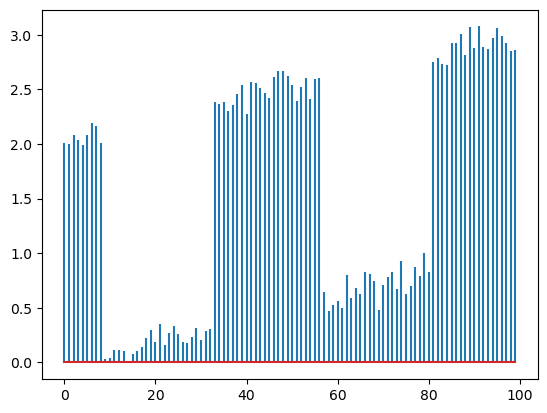

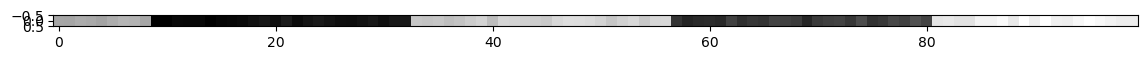

In [2]:
u = np.abs(1 + np.sign(np.sin(np.linspace(2, 15, 100)))
             + np.linspace(0, 1, 100)
             + rng.normal(0, 0.1, size=100))

plot_signal(u)

To detect jumps in the signal we may use a suitable filter, looking itself like a jump in a signal.

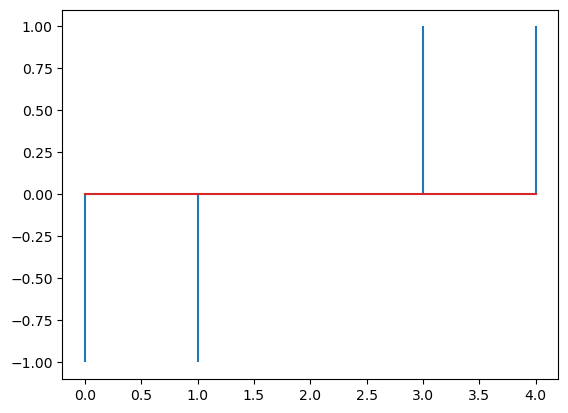

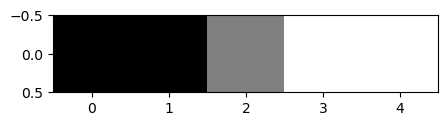

In [3]:
w = np.array([-1, -1, 0, 1, 1])

plot_signal(w)

The filtered signal (that is, the convolution of signal and filter) has peaks at the jump positions and is almost zero else.

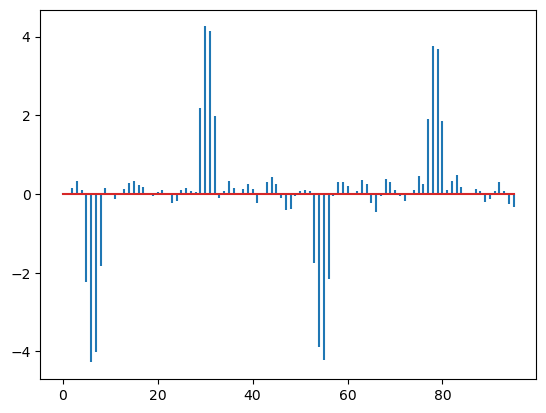

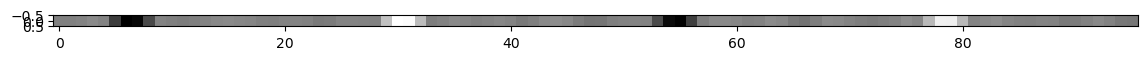

In [4]:
conv = np.empty(u.size - w.size + 1)
for k in range(0, conv.size):
    conv[k] = np.sum(u[k:(k + w.size)] * w)

plot_signal(conv)

Another application of filters is blurring for noise reduction.

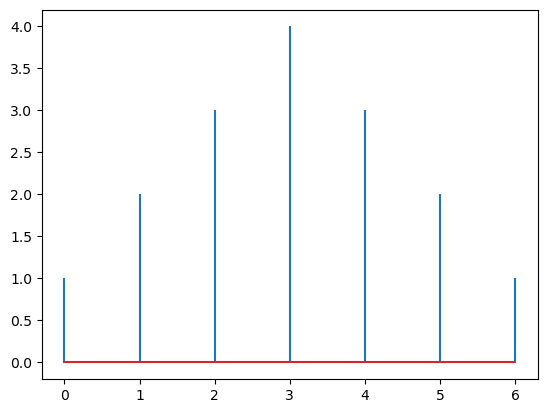

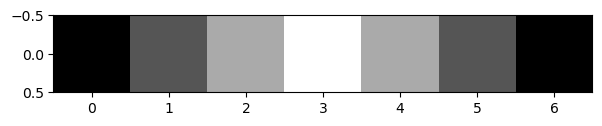

In [5]:
w = np.array([1, 2, 3, 4, 3, 2, 1])

plot_signal(w)

The filtered signal shows less oscillations.

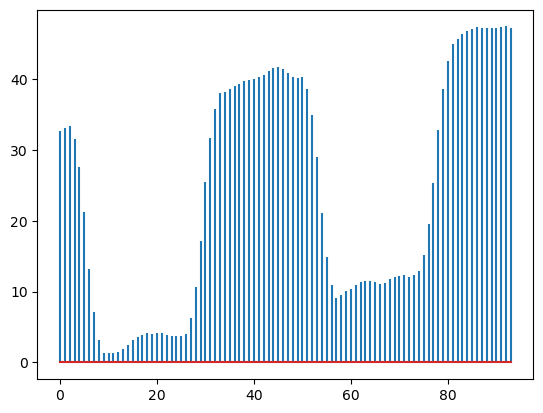

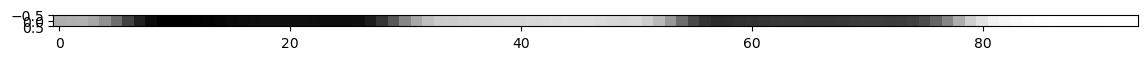

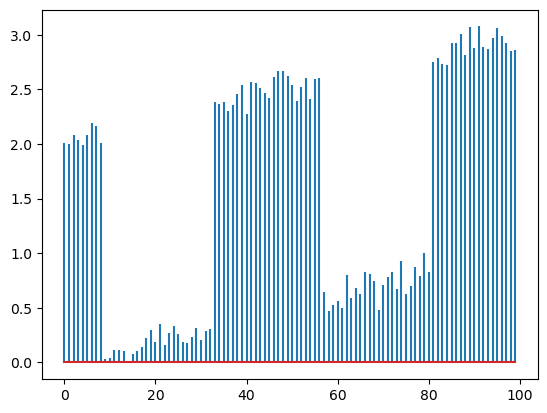

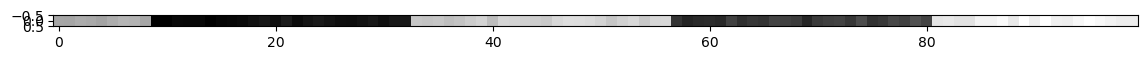

In [6]:
conv = np.empty(u.size - w.size + 1)
for k in range(0, conv.size):
    conv[k] = np.sum(u[k:(k + w.size)] * w)

plot_signal(conv)
plot_signal(u)

Filtering decreases signal length slightly. To avoid this effect one can add sufficiently many zeros at both sides of the signel ($\frac{p-1}{2}$ zeros at each side if $p$ is the filter length). Then filtering can start with the filter centered at the first regular signal value.

```{figure} zeropadding.svg
---
alt: scheme for computing 1d convolutions with zero padding
---
With zero padding original and filtered signal are of same length.
```

Whether zero padding is necessary and appropriate has to be decided from case to case. It's important to keep in mind that zero padding adds artificial information to the signal. Maybe the signal is a slice of a longer signal. Then zero padding adds the information that the longer signal is zero before and after the sliced signal. That might be wrong.

## Convolutions in 2d

Let $u$ be a large matrix (a gray scale image for instance) and $w$ be a small matrix. The convolution of $u$ and $w$ is defined analogously to the 1d case, yielding a matrix of almost the same size as $u$. Number of rows is decreased by the number of rows in $w$ minus 1. Same for the columns. We skip mathematical formulas and content ourselves with an example.

```{figure} conv2d.svg
---
alt: scheme for computing 2d convolutions
---
Computations for 2d convolutions follow the same scheme as for 1d convolutions.
```

Like in 1d we may use convolutions to detect certain features in images or to remove noise. Here is an edge detection example:

In [7]:
import imageio.v3 as imageio

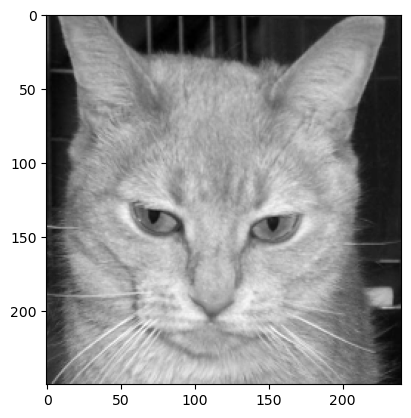

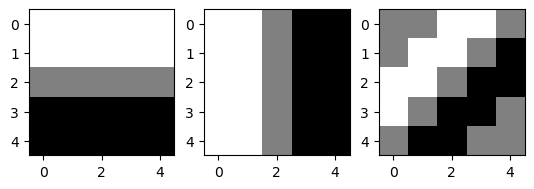

In [8]:
u = imageio.imread('cat.png')[:, :, 0]
plt.imshow(u, cmap='gray')
plt.show()

wh = np.array([[1, 1, 1, 1, 1],
               [1, 1, 1, 1, 1],
               [0, 0, 0, 0, 0],
               [-1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1]])
wv = wh.T
wd = np.array([[0, 0, 1, 1, 0],
               [0, 1, 1, 0, -1],
               [1, 1, 0, -1, -1],
               [1, 0, -1, -1, 0],
               [0, -1, -1, 0, 0]])

fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
ax1.imshow(wh, cmap='gray')
ax2.imshow(wv, cmap='gray')
ax3.imshow(wd, cmap='gray')
plt.show()

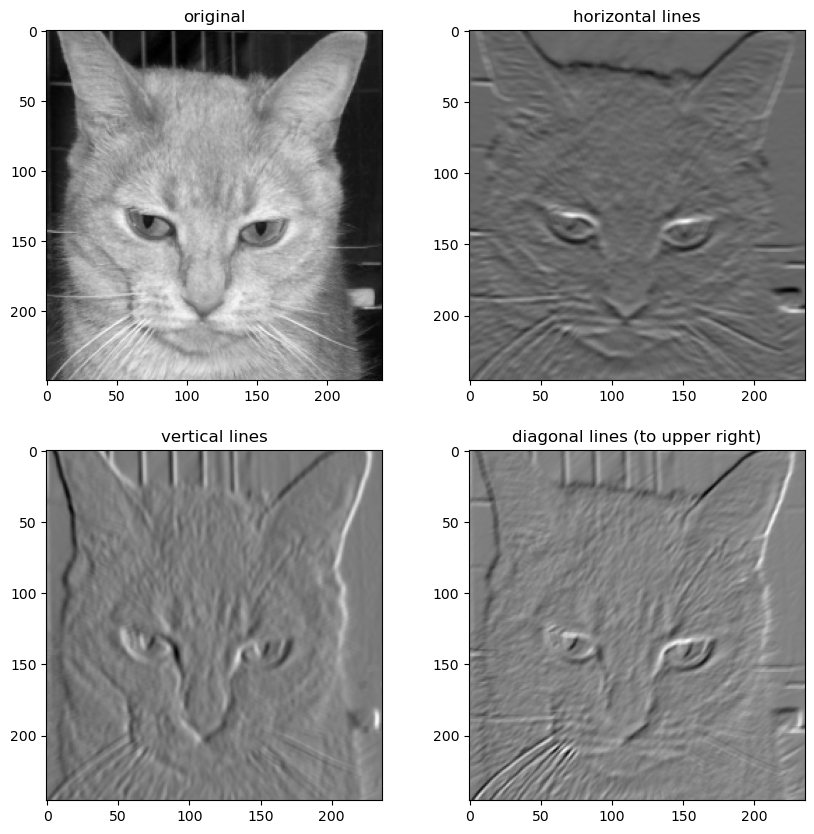

In [9]:
def get_conv2d(u, w):
    conv = np.empty((u.shape[0] - w.shape[0] + 1, u.shape[1] - w.shape[1] + 1))
    for k in range(0, conv.shape[0]):
        for l in range(0, conv.shape[1]):
            conv[k, l] = np.sum(u[k:(k + w.shape[0]), l:(l + w.shape[1])] * w)
    return conv

convh = get_conv2d(u, wh)
convv = get_conv2d(u, wv)
convd = get_conv2d(u, wd)

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10, 10))
ax1.imshow(u, cmap='gray')
ax1.set_title('original')
ax2.imshow(convh, cmap='gray')
ax2.set_title('horizontal lines')
ax3.imshow(convv, cmap='gray')
ax3.set_title('vertical lines')
ax4.imshow(convd, cmap='gray')
ax4.set_title('diagonal lines (to upper right)')
plt.show()

## Convolutions in 3d

Digital color images are represented as a set of three matrices in computer science. Each pixel's color is composed of certain amounts of red, green and blue (additive color mixing, see [Wikipedia on color mixing](https://en.wikipedia.org/wiki/Color_mixing)). One says that the image has three color channels, the red channel, the green channel and the blue channel. Each single channel can be considered a gray scale image. Sometimes there is also a fourth channel, the alpha channel. The alpha channel contains information on transparency (small values for opaque pixels, high values for transparent pixels).

(224, 224, 3)


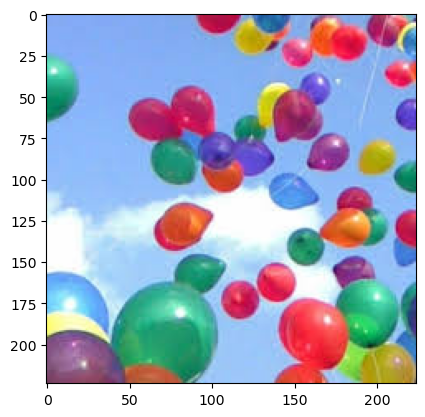

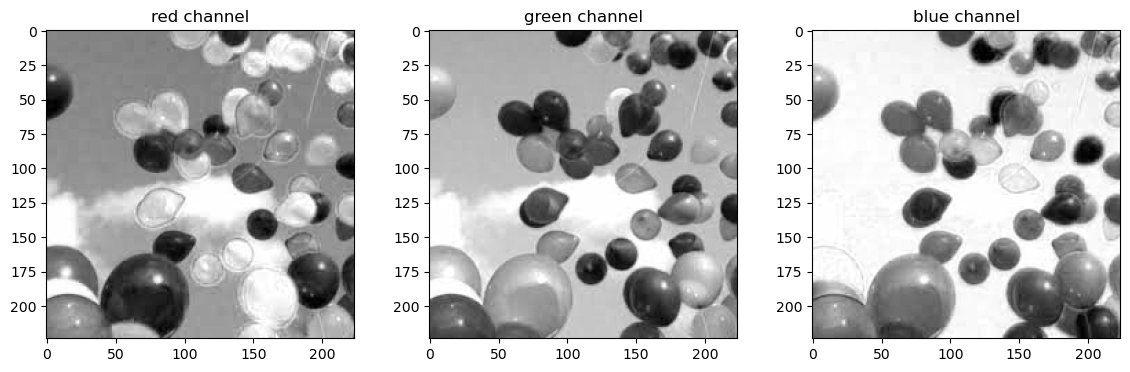

In [10]:
u = imageio.imread('balloons.png')[:, :, 0:3]
print(u.shape)
plt.imshow(u)
plt.show()

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14,4))
ax1.imshow(u[:, :, 0], cmap='gray')
ax1.set_title('red channel')
ax2.imshow(u[:, :, 1], cmap='gray')
ax2.set_title('green channel')
ax3.imshow(u[:, :, 2], cmap='gray')
ax3.set_title('blue channel')
plt.show()

Filters in 3d are cuboids of numbers (or stacks of matrices or tensors of rank 3). Convolution takes a subcuboid of the color image, multiplies componentwise by the filter, and then sums up all the products.

We may use 3d convolution for color extraction: If we want to mark regions with red colored objects, we could look at the red channel. But white or yellow or pink objects have maximum values at the red channel, too. Filtering allows to look for differences between channels. We may think of color extraction as looking for jumps or edges in the depth direction.

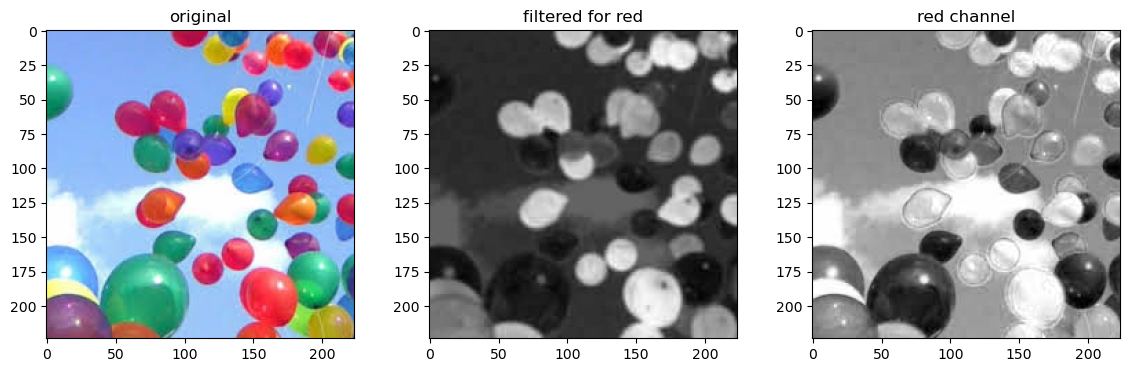

In [11]:
w = np.array([1, -0.5, -0.5]).reshape(1, 1, 3)

conv = np.empty((u.shape[0] - w.shape[0] + 1, u.shape[1] - w.shape[1] + 1, u.shape[2] - w.shape[2] + 1))
for k in range(0, conv.shape[0]):
    for l in range(0, conv.shape[1]):
        for m in range(0, conv.shape[2]):
            conv[k, l, m] = np.sum(u[k:(k + w.shape[0]), l:(l + w.shape[1]), m:(m + w.shape[2])] * w)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14,4))
ax1.imshow(u)
ax1.set_title('original')
ax2.imshow(conv, cmap='gray')
ax2.set_title('filtered for red')
ax3.imshow(u[:, :, 0], cmap='gray')
ax3.set_title('red channel')
plt.show()

## Convolutional Layers

CNNs mainly contain so called convolutional layers. A 1d convolutional layer takes a multi-channel signal as input, a 2d convolutional layer takes a multi-channel image as input. The output is a list of filtered signals or images, which again can be considered as a multi-channel signal or image. Filter size in the depth dimension equals the number of input channels. Thus, there is exactly one output channel per filter. The output of a convolutional layer is sometimes referred to as *feature map*, because it contains information about certain features of the input.

Filters correspond to the ANN's weights as follows:
* A convolutional layer has as many neurons as the filtered signal or image has components and neurons are (mentally) arranged in the same layout as the signal's or image's components.
* Each neuron gets input only from the signal or image components used for calculating corresponding component of the convolution (*local connectivity*).
* Weights play the role of the filter's components. Thus, all neurons share the same set of weights (*weight sharing*).

```{figure} convlayer.svg
---
alt: scheme of convolutional layer with inputs and feature maps
---
Convolutional layers take a stack of signals/images and yield a stack of filtered signals/images.
```

Filters for convolution layers are not prescribed as in classical image processing. Instead the CNN has to learn useful filters from training data. As for usual ANNs each layer may get input from an additional bias neuron.

Convolutional layers may have a further parameter: the *stride*. A stride of 1 means that we consider every component of the filtered signal or image. With a stride of 2 we only keep every second component, and so on. Strides greater than one should be used only in combination with large filters. Else we would miss too much information.

Often rectified linear units are used as neurons in convolutional layers. Negative activations indicate presence of features that contradict the filter. If we only want to know if the feature corresponding to a filter is in the image, then the interpretation of negative and zero activation is identical (feature not present in both cases). Thus, it seems reasonable to cut off negative acitvations. That is exactly what rectified linear units do.

The principles of local connectivity and weight sharing lead to much fewer weights to be trained, thus allowing for deeper networks.

## Overall CNN structure

Typical CNNs contain a stack of convolutional layers followed by a stack of dense layers. The idea is that the convolutional layers extract features from the inputs and the dense layers combine extracted features to predictions.

The deeper a convolutional layer in the stack the larger the area of the input image having influence on the layer activations. Thus, deeper layers extract less localized features, whereas the first layers only have access to very small regions of the input image.

The stack of convolutional layers may contain so called *pooling layers*. A pooling layer samples feature maps down to smaller feature maps. Usually each feature map is split into disjoint pieces of size 2x2 and each piece is replaced by its average value (*average pooling*) or the maximum value (*max pooling*). The idea behind pooling is that features will not vary much locally or that only most relevant features are of interest locally. Max pooling seems to yield better results than average pooling, but the need for pooling at all is controversial. From the computational point of view pooling reduces feature map sizes and thus the number of weights to train. 

```{figure} cnnstructure.svg
---
alt: structure of CNNs with convolutions, pooling, dense layers
---
CNNs typically consist of serveral convolution stacks and a small number of dense layers.
```